## Title: Global and Regional Evaluation of BCC-CSM2-MR & BCC-ESM1 (CMIP6) Against ERA5

This repository contains a Python-based evaluation of two CMIP6 climate models (BCC-ESM1 and BCC-CSM2-MR) against ERA5 reanalysis data. The analysis includes:

    Global-scale assessment of precipitation and temperature patterns, biases, and spatial correlations

    Focused regional evaluation for Cameroon's Central Region (1981-2010)

    Quantitative comparison of model performance through:

        Bias calculations (model vs observations)

        Seasonal trend analysis

        Spatial correlation metrics

The project provides visualizations of global climate patterns and regional climatologies, offering insights into model reliability for climate studies in West Africa. Technical implementation uses xarray, matplotlib, and cartopy for efficient processing of NetCDF data and map generation

###  Python code for conversion: Hourly Precipitation Rate to Daily Accumulated Precipitation Using Xarray

In [3]:
import xarray as xr

# 1. Load hourly evaporation data (kg·m⁻²·s⁻¹)
ds = xr.open_dataset('precip_observed.nc')

# 2. Convert to hourly accumulated values (kg·m⁻²·h⁻¹ or mm/h)
prec_obs_mmdayy = ds['avg_tprate'] * 86400  # Multiply by seconds in an hour

# 4. Save the result
prec_obs_mmdayy.to_netcdf('prec_obs_mmday.nc')  

### I) EVALUATION OF THE GLOBAL MAP ANALYSIS

### Temporal Correlation Analysis of Annual Mean Precipitation and Temperature Between Observed and Modeled Climate Data using CDO

In [114]:
#!/bin/bash

# ====== INPUT FILES ======
OBS_PREC_FILE=".nc"
OBS_TEMP_FILE=".nc"
MODEL1_PREC_FILE="pr_BCC_ESM1_mmday_west.nc"
MODEL2_PREC_FILE="pr_BCC_CSM2_MR_mmday_west.nc"
MODEL1_TEMP_FILE="tas_BCC_ESM1_west_date.nc"
MODEL2_TEMP_FILE="tas_BCC_CSM2_MR_west_date.nc"

# ====== OUTPUT PREFIXES ======
OBS_PREFIX="obs_analysis"
MODEL1_PREFIX="BCC_ESM1"
MODEL2_PREFIX="BCC_CSM2"

# ====== A. PROCESS OBSERVED DATA ======
echo "Processing observed data..."

# Temperature conversion
cdo subc,273.15 "$OBS_TEMP_FILE" "${OBS_PREFIX}_temp_C.nc"

# Annual means for timcor calculations
cdo yearmean "$OBS_PREC_FILE" "${OBS_PREFIX}_precip_annual.nc"
cdo yearmean "${OBS_PREFIX}_temp_C.nc" "${OBS_PREFIX}_temp_annual.nc"

# ====== B. PROCESS MODEL DATA ======
echo "Processing ${MODEL1_PREFIX} data..."
# Temperature conversion
cdo subc,273.15 "$MODEL1_TEMP_FILE" "${MODEL1_PREFIX}_temp_C.nc"
# Annual means for timcor calculations
cdo yearmean "$MODEL1_PREC_FILE" "${MODEL1_PREFIX}_precip_annual.nc"
cdo yearmean "${MODEL1_PREFIX}_temp_C.nc" "${MODEL1_PREFIX}_temp_annual.nc"

echo "Processing ${MODEL2_PREFIX} data..."
# Temperature conversion
cdo subc,273.15 "$MODEL2_TEMP_FILE" "${MODEL2_PREFIX}_temp_C.nc"
# Annual means for timcor calculations
cdo yearmean "$MODEL2_PREC_FILE" "${MODEL2_PREFIX}_precip_annual.nc"
cdo yearmean "${MODEL2_PREFIX}_temp_C.nc" "${MODEL2_PREFIX}_temp_annual.nc"

# ====== C. COMPARE MODELS WITH OBSERVATIONS ======
# ----- MODEL 1 ----- 
echo "Computing temporal correlations for ${MODEL1_PREFIX}..."

# Precipitation temporal correlation
cdo timcor "${OBS_PREFIX}_precip_annual.nc" "${MODEL1_PREFIX}_precip_annual.nc" "${MODEL1_PREFIX}_precip_timcor.nc"

# Temperature temporal correlation
cdo timcor "${OBS_PREFIX}_temp_annual.nc" "${MODEL1_PREFIX}_temp_annual.nc" "${MODEL1_PREFIX}_temp_timcor.nc"

# ----- MODEL 2 -----
echo "Computing temporal correlations for ${MODEL2_PREFIX}..."

# Precipitation temporal correlation
cdo timcor "${OBS_PREFIX}_precip_annual.nc" "${MODEL2_PREFIX}_precip_annual.nc" "${MODEL2_PREFIX}_precip_timcor.nc"

# Temperature temporal correlation
cdo timcor "${OBS_PREFIX}_temp_annual.nc" "${MODEL2_PREFIX}_temp_annual.nc" "${MODEL2_PREFIX}_temp_timcor.nc"

echo "All temporal correlation calculations completed successfully!" 

Computing comparison metrics for BCC_CSM2_MR...


cdo    sub (Warning): Input parameters have different levels!
cdo    fldcor (Warning): Input parameters have different levels!
cdo    sub (Warning): Input parameters have different levels!


### a1) Temperature Bias

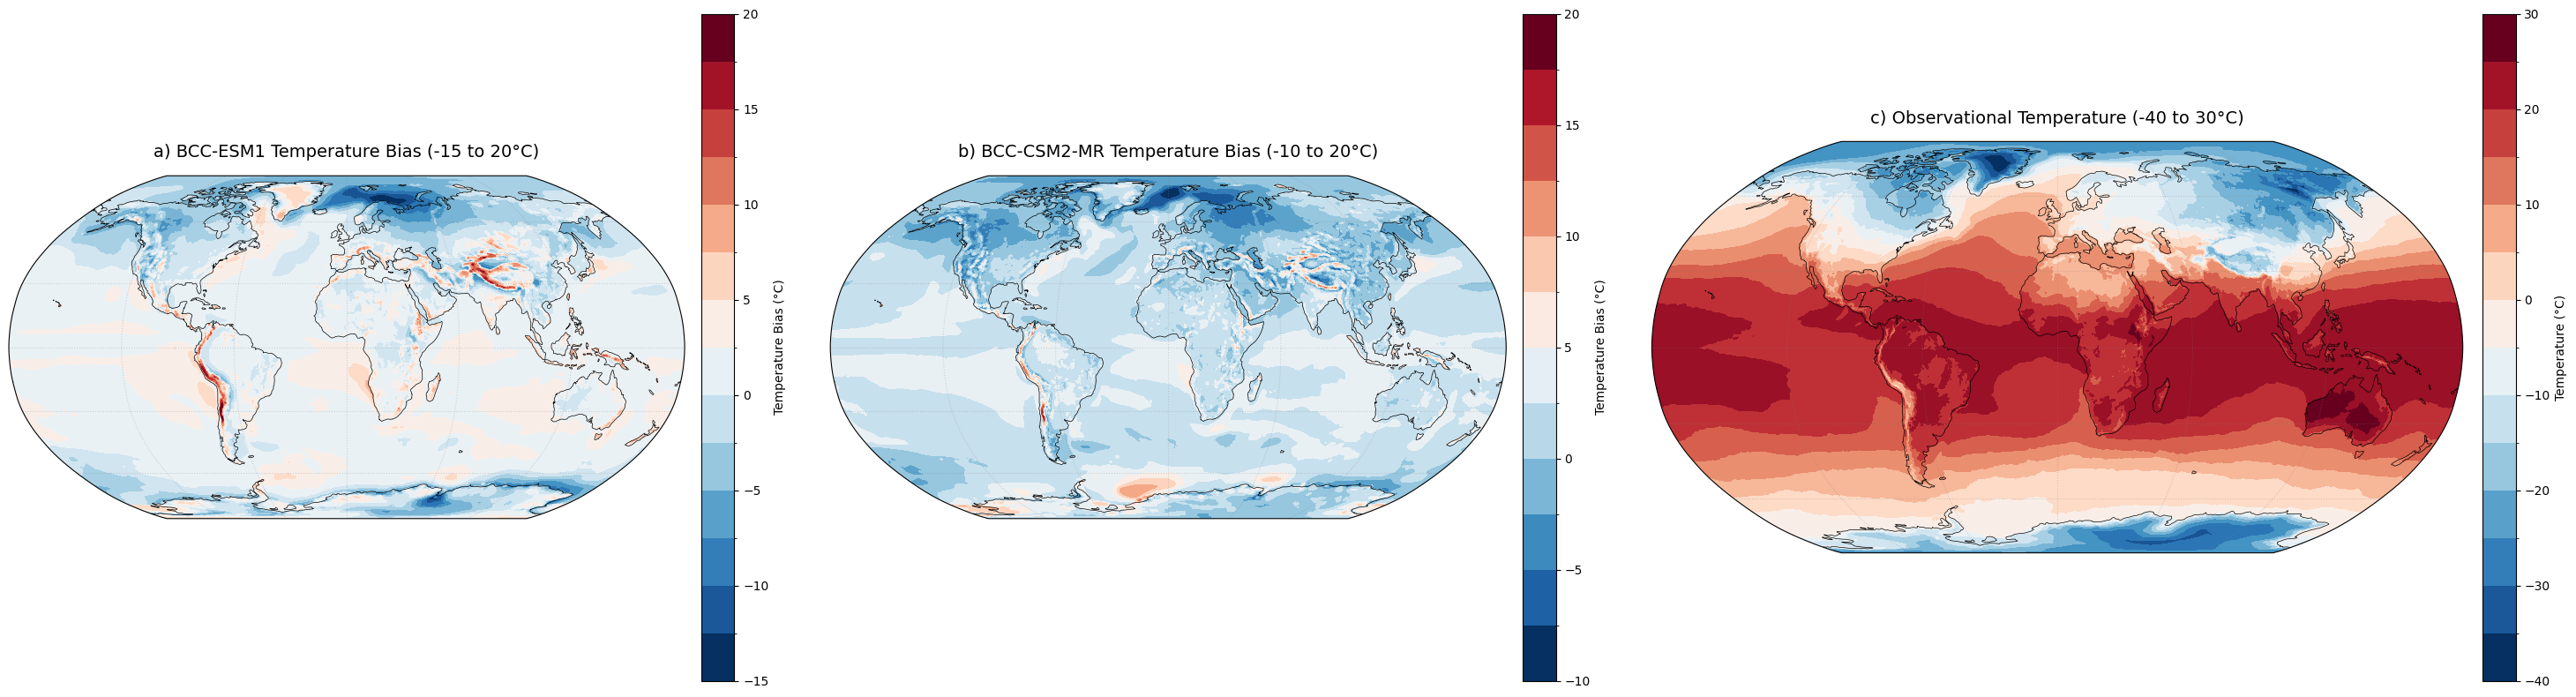

In [128]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

# Load data
bias_temp1 = xr.open_dataset('BCC_ESM1_temp_bias.nc')['tas'].isel(time=0)
bias_temp2 = xr.open_dataset('BCC_CSM2_temp_bias.nc')['tas'].isel(time=0)
obs_temp = xr.open_dataset('obs_analysis_temp_C.nc')['t2m'].isel(valid_time=0)

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8),
                                   subplot_kw={'projection': ccrs.Robinson()},
                                   gridspec_kw={'width_ratios': [1, 1, 1.2]})

cmap = plt.cm.RdBu_r  # Use RdBu_r for ALL plots

# Define levels
levels_bias1 = np.linspace(-15, 20, 15)
levels_bias2 = np.linspace(-10, 20, 13)
levels_obs = np.linspace(-40, 30, 15)  # -40 to 30°C range for observations

# Plot BCC-ESM1 Bias
contour1 = bias_temp1.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),
                                  cmap=cmap, levels=levels_bias1,
                                  extend='both', add_colorbar=False)
ax1.coastlines(linewidth=0.5)
ax1.gridlines(color='gray', linestyle=':', alpha=0.3)
ax1.set_title('a) BCC-ESM1 Temperature Bias (-15 to 20°C)', fontsize=14, pad=15)

# Plot BCC-CSM2-MR Bias
contour2 = bias_temp2.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),
                                  cmap=cmap, levels=levels_bias2,
                                  extend='both', add_colorbar=False)
ax2.coastlines(linewidth=0.5)
ax2.gridlines(color='gray', linestyle=':', alpha=0.3)
ax2.set_title('b) BCC-CSM2-MR Temperature Bias (-10 to 20°C)', fontsize=14, pad=15)

# Plot Observational Data (using same RdBu_r colormap)
contour3 = obs_temp.plot.contourf(ax=ax3, transform=ccrs.PlateCarree(),
                                cmap=cmap, levels=levels_obs,
                                extend='both', add_colorbar=False)
ax3.coastlines(linewidth=0.5)
ax3.gridlines(color='gray', linestyle=':', alpha=0.3)
ax3.set_title('c) Observational Temperature (-40 to 30°C)', fontsize=14, pad=15)

# Create colorbars with consistent styling
norm1 = BoundaryNorm(levels_bias1, cmap.N)
norm2 = BoundaryNorm(levels_bias2, cmap.N)
norm3 = BoundaryNorm(levels_obs, cmap.N)

sm1 = ScalarMappable(norm=norm1, cmap=cmap)
sm2 = ScalarMappable(norm=norm2, cmap=cmap)
sm3 = ScalarMappable(norm=norm3, cmap=cmap)

# Add colorbars
cbar1 = fig.colorbar(sm1, ax=ax1, orientation='vertical', pad=0.02,
                    label='Temperature Bias (°C)', ticks=np.arange(-15, 21, 5))
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', pad=0.02,
                    label='Temperature Bias (°C)', ticks=np.arange(-10, 21, 5))
cbar3 = fig.colorbar(sm3, ax=ax3, orientation='vertical', pad=0.02,
                    label='Temperature (°C)', ticks=np.linspace(-40, 30, 8))

plt.tight_layout()
plt.savefig('Temperature_Comparison_UniformColormap.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### a2) Precipitation Bias

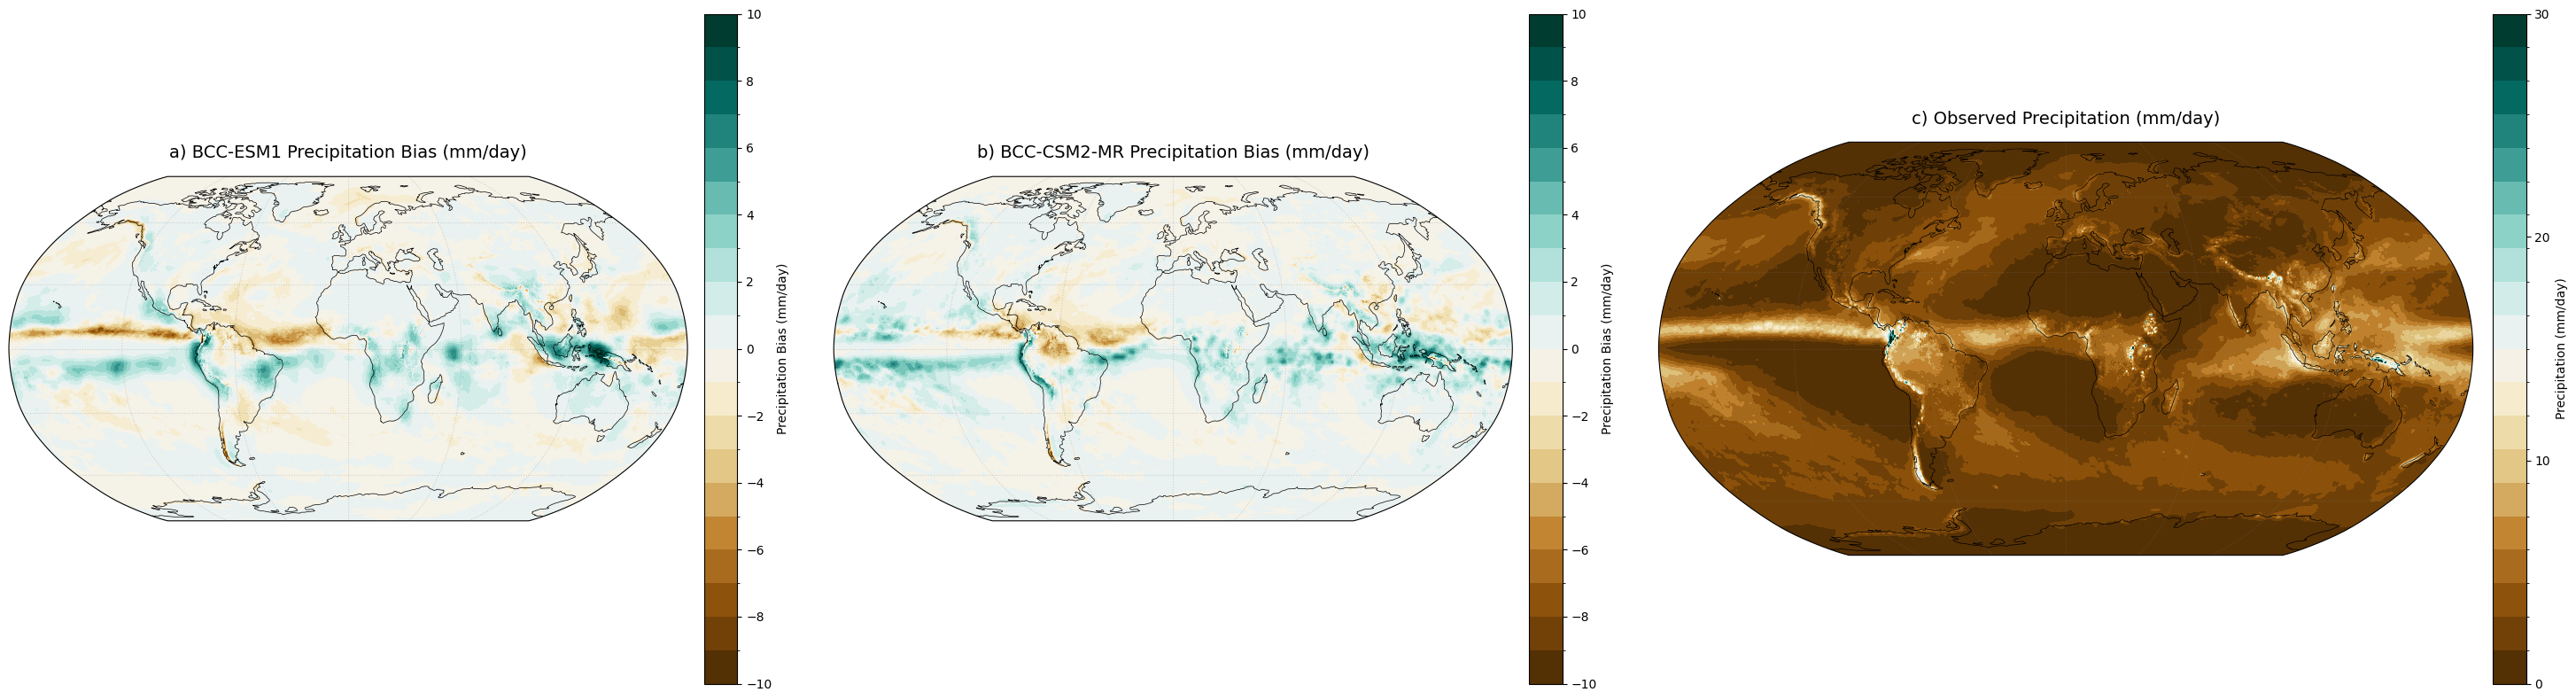

In [158]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

# Load data
bias_precip1 = xr.open_dataset('BCC_ESM1_precip_bias.nc')['pr'].isel(time=0)
bias_precip2 = xr.open_dataset('BCC_CSM2_precip_bias.nc')['pr'].isel(time=0)
obs_precip = xr.open_dataset('precip_observed_mmday_yrmean.nc')['avg_tprate'].isel(valid_time=0)

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8),
                                   subplot_kw={'projection': ccrs.Robinson()},
                                   gridspec_kw={'width_ratios': [1, 1, 1.2]})

# Use BrBG colormap for ALL plots
cmap = plt.cm.BrBG  # Brown-Blue-Green colormap

# Define levels
levels_bias = np.linspace(-10, 10, 21)  
levels_obs = np.linspace(0, 30, 21)     

# Plot BCC-ESM1 Bias
contour1 = bias_precip1.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),
                                    cmap=cmap, levels=levels_bias,
                                    extend='both', add_colorbar=False)
ax1.coastlines(linewidth=0.5)
ax1.gridlines(color='gray', linestyle=':', alpha=0.3)
ax1.set_title('a) BCC-ESM1 Precipitation Bias (mm/day)', fontsize=14, pad=15)

# Plot BCC-CSM2-MR Bias
contour2 = bias_precip2.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),
                                    cmap=cmap, levels=levels_bias,
                                    extend='both', add_colorbar=False)
ax2.coastlines(linewidth=0.5)
ax2.gridlines(color='gray', linestyle=':', alpha=0.3)
ax2.set_title('b) BCC-CSM2-MR Precipitation Bias (mm/day)', fontsize=14, pad=15)

# Plot Observational Data (using same BrBG colormap)
contour3 = obs_precip.plot.contourf(ax=ax3, transform=ccrs.PlateCarree(),
                                  cmap=cmap, levels=levels_obs,
                                  extend='max', add_colorbar=False)
ax3.coastlines(linewidth=0.5)
ax3.gridlines(color='gray', linestyle=':', alpha=0.3)
ax3.set_title('c) Observed Precipitation (mm/day)', fontsize=14, pad=15)

# Create colorbars
norm_bias = BoundaryNorm(levels_bias, cmap.N)
norm_obs = BoundaryNorm(levels_obs, cmap.N)

sm_bias = ScalarMappable(norm=norm_bias, cmap=cmap)
sm_obs = ScalarMappable(norm=norm_obs, cmap=cmap)

# Add colorbars
cbar1 = fig.colorbar(sm_bias, ax=ax1, orientation='vertical', pad=0.02,
                    label='Precipitation Bias (mm/day)', ticks=np.arange(-10, 11, 2))
cbar2 = fig.colorbar(sm_bias, ax=ax2, orientation='vertical', pad=0.02,
                    label='Precipitation Bias (mm/day)', ticks=np.arange(-10, 11, 2))
cbar3 = fig.colorbar(sm_obs, ax=ax3, orientation='vertical', pad=0.02,
                    label='Precipitation (mm/day)', ticks=np.arange(0, 81, 10)) 

plt.tight_layout()
plt.savefig('Precipitation_Comparison_UniformColormap.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### b1) Temperature Correlation

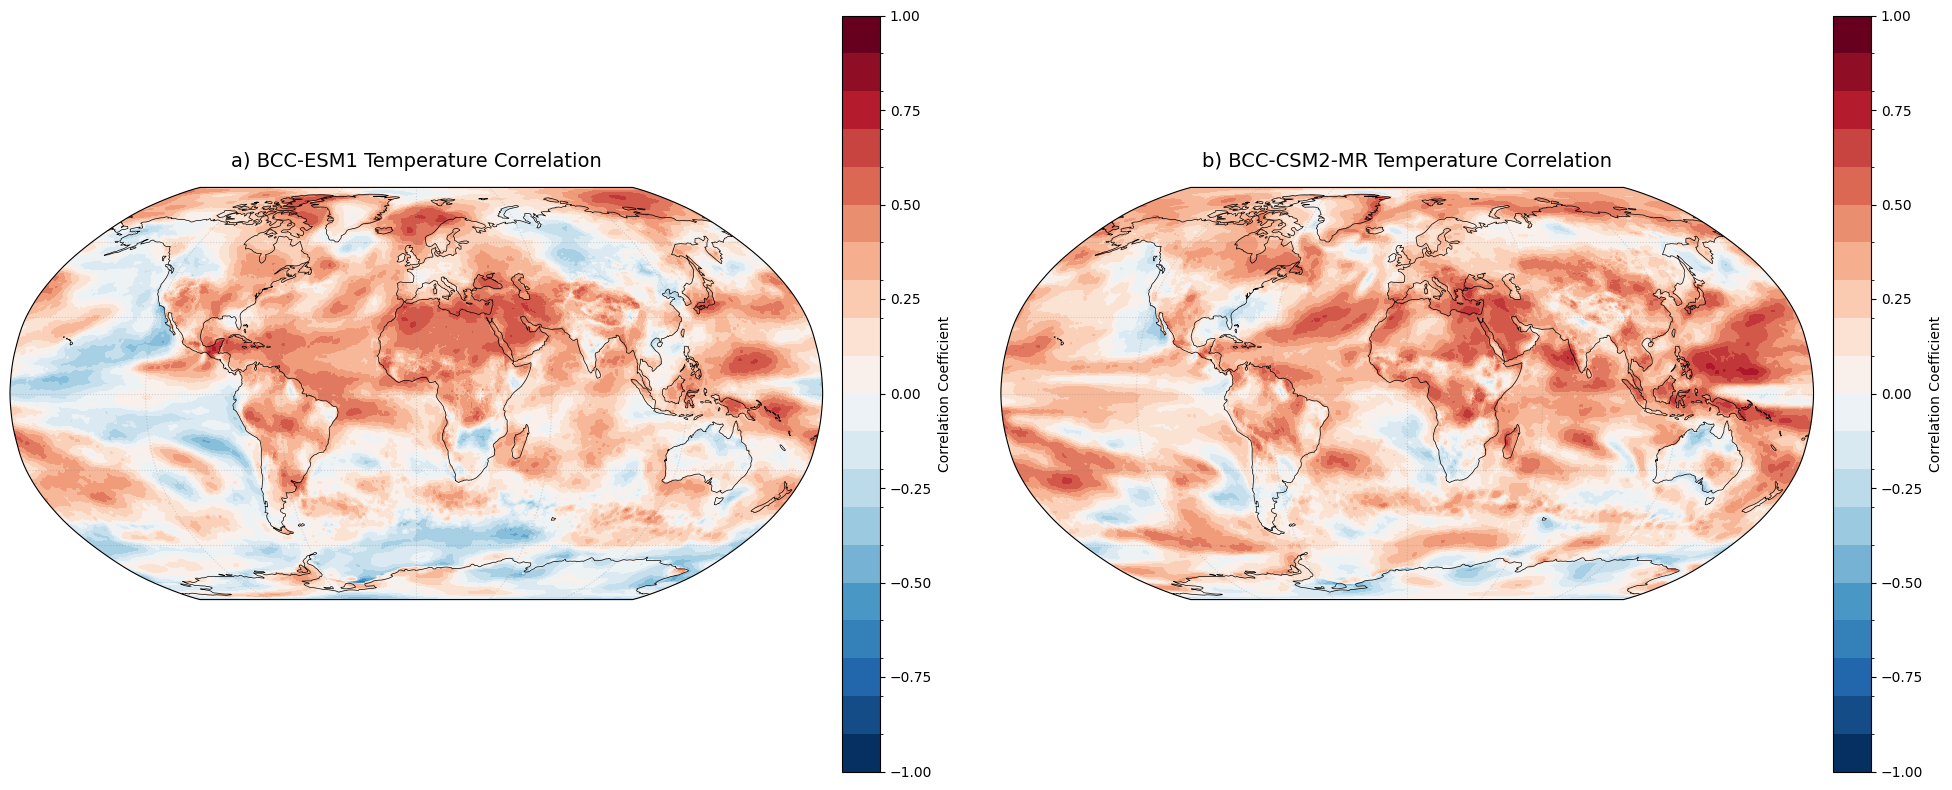

In [180]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

# Load data
bias_temp1 = xr.open_dataset('BCC_ESM1_temp_annual_timcor.nc')['t2m'].isel(valid_time=0)
bias_temp2 = xr.open_dataset('BCC_CSM2_temp_annual_timcor.nc')['t2m'].isel(valid_time=0)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8),
                              subplot_kw={'projection': ccrs.Robinson()})

cmap = plt.cm.RdBu_r  # Red-Blue colormap for correlations

# Define levels for correlation coefficients (-1 to 1)
levels_corr = np.linspace(-1, 1, 21)  # 21 levels for smooth gradient

# Plot BCC-ESM1 Correlation
contour1 = bias_temp1.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),
                                  cmap=cmap, levels=levels_corr,
                                  extend='both', add_colorbar=False)
ax1.coastlines(linewidth=0.5)
ax1.gridlines(color='gray', linestyle=':', alpha=0.3)
ax1.set_title('a) BCC-ESM1 Temperature Correlation', fontsize=14, pad=15)

# Plot BCC-CSM2-MR Correlation
contour2 = bias_temp2.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),
                                  cmap=cmap, levels=levels_corr,
                                  extend='both', add_colorbar=False)
ax2.coastlines(linewidth=0.5)
ax2.gridlines(color='gray', linestyle=':', alpha=0.3)
ax2.set_title('b) BCC-CSM2-MR Temperature Correlation', fontsize=14, pad=15)

# Create colorbar normalization
norm_corr = BoundaryNorm(levels_corr, cmap.N)
sm_corr = ScalarMappable(norm=norm_corr, cmap=cmap)

# Add colorbars
cbar1 = fig.colorbar(sm_corr, ax=ax1, orientation='vertical', pad=0.02,
                    label='Correlation Coefficient', ticks=np.linspace(-1, 1, 9))
cbar2 = fig.colorbar(sm_corr, ax=ax2, orientation='vertical', pad=0.02,
                    label='Correlation Coefficient', ticks=np.linspace(-1, 1, 9))

plt.tight_layout()
plt.savefig('Temperature_Correlation_Comparison.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### b1) Precipitation Correlation

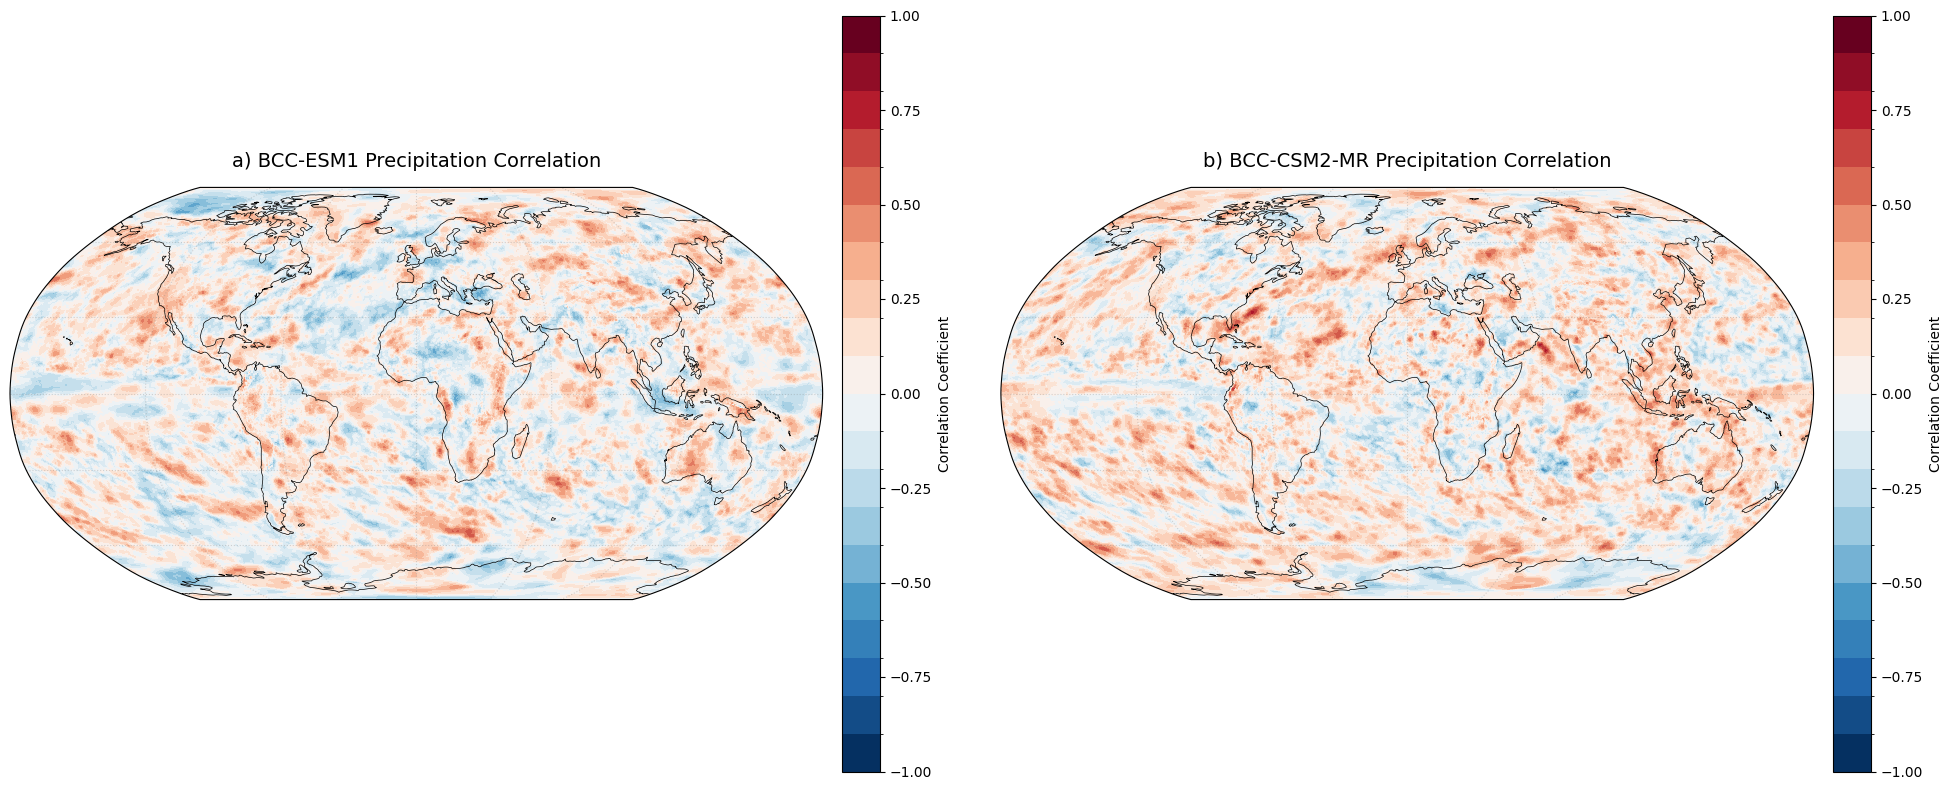

In [186]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

# Load data
bias_temp1 = xr.open_dataset('BCC_ESM1_precip_annual_FLIPPED_timcor.nc')['avg_tprate'].isel(valid_time=0)
bias_temp2 = xr.open_dataset('BCC_CSM2_precip_annual_FLIPPED_timcor.nc')['avg_tprate'].isel(valid_time=0)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8),
                              subplot_kw={'projection': ccrs.Robinson()})

cmap = plt.cm.RdBu_r  # Red-Blue colormap for correlations

# Define levels for correlation coefficients (-1 to 1)
levels_corr = np.linspace(-1, 1, 21)  # 21 levels for smooth gradient

# Plot BCC-ESM1 Correlation
contour1 = bias_temp1.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),
                                  cmap=cmap, levels=levels_corr,
                                  extend='both', add_colorbar=False)
ax1.coastlines(linewidth=0.5)
ax1.gridlines(color='gray', linestyle=':', alpha=0.3)
ax1.set_title('a) BCC-ESM1 Precipitation Correlation', fontsize=14, pad=15)

# Plot BCC-CSM2-MR Correlation
contour2 = bias_temp2.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),
                                  cmap=cmap, levels=levels_corr,
                                  extend='both', add_colorbar=False)
ax2.coastlines(linewidth=0.5)
ax2.gridlines(color='gray', linestyle=':', alpha=0.3)
ax2.set_title('b) BCC-CSM2-MR Precipitation Correlation', fontsize=14, pad=15)

# Create colorbar normalization
norm_corr = BoundaryNorm(levels_corr, cmap.N)
sm_corr = ScalarMappable(norm=norm_corr, cmap=cmap)

# Add colorbars
cbar1 = fig.colorbar(sm_corr, ax=ax1, orientation='vertical', pad=0.02,
                    label='Correlation Coefficient', ticks=np.linspace(-1, 1, 9))
cbar2 = fig.colorbar(sm_corr, ax=ax2, orientation='vertical', pad=0.02,
                    label='Correlation Coefficient', ticks=np.linspace(-1, 1, 9))

plt.tight_layout()
plt.savefig('Precipitation_Correlation_Comparison.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show() 

## Study  Analysis: West Cameroon

In [482]:
%%bash

# To work with the ERA5 resolution wich is about 0.25 
cdo remapbil,r1440x721 pr_mon_BCC-ESM1_historical_r1i1p1f1_gn_18500101-20141231.nc pr_BCC_ESM1.nc
cdo remapbil,r1440x721 pr_mon_BCC-CSM2-MR_historical_r1i1p1f1_gn_18500101-20141231.nc pr_BCC_CSM2.nc
cdo remapbil,r1440x721 tas_Amon_BCC-ESM1_historical_r1i1p1f1_gn_18500101-20141231.nc tas_BCC_ESM1.nc
cdo remapbil,r1440x721 tas_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_18500101-20141231.nc tas_BCC_CSM2_MR.nc

cdo    remapbil: Bilinear weights from gaussian (128x64) to lonlat (1440x721) grid
cdo    remapbil: Bilinear weights from gaussian (320x160) to lonlat (1440x721) grid


In [483]:
%%bash 
cdo sellonlatbox,9.8,11.8,4.46,6.46 tas_BCC_ESM1.nc tas_BCC_ESM1_west.nc
cdo sellonlatbox,9.8,11.8,4.46,6.46 tas_BCC_CSM2_MR.nc tas_BCC_CSM2_MR_west.nc
cdo sellonlatbox,9.8,11.8,4.46,6.46 pr_BCC_ESM1.nc pr_BCC_ESM1_west.nc
cdo sellonlatbox,9.8,11.8,4.46,6.46 pr_BCC_CSM2.nc pr_BCC_CSM2_west.nc
cdo sellonlatbox,9.8,11.8,4.46,6.46 temp_observed.nc temp_observed_west.nc
cdo sellonlatbox,9.8,11.8,4.46,6.46 precip_observed.nc precip_observed_west.nc 

In [484]:
%%bash
cdo seldate,1981-01-01,2010-12-01 tas_BCC_ESM1_west.nc tas_BCC_ESM1_west_date.nc
cdo seldate,1981-01-01,2010-12-01 tas_BCC_CSM2_MR_west.nc tas_BCC_CSM2_MR_west_date.nc 
cdo seldate,1981-01-01,2010-12-01 pr_BCC_ESM1_west.nc pr_BCC_ESM1_west_date.nc 
cdo seldate,1981-01-01,2010-12-01 pr_BCC_CSM2_west.nc pr_BCC_CSM2_west_date.nc

In [301]:
%%bash

1. Convert units # kg/m²/s → kg/m²/day 
cdo mulc,86400 pr_BCC_ESM1_west_date.nc pr_BCC_ESM1_mmday_west.nc
cdo mulc,86400 pr_BCC_CSM2_west_date.nc pr_BCC_CSM2_MR_mmday_west.nc
cdo mulc,86400 precip_observed_west.nc precip_observed_mmday_west.nc 

In [ ]:
#!/bin/bash

# ====== INPUT FILES ======
OBS_PREC_FILE="precip_observed_mmday_west.nc"
OBS_TEMP_FILE="temp_observed_west.nc"
MODEL1_PREC_FILE="pr_BCC_ESM1_mmday_west.nc"
MODEL2_PREC_FILE="pr_BCC_CSM2_MR_mmday_west.nc"
MODEL1_TEMP_FILE="tas_BCC_ESM1_west_date.nc"
MODEL2_TEMP_FILE="tas_BCC_CSM2_MR_west_date.nc"

# ====== OUTPUT PREFIXES ======
OBS_PREFIX="obs_analysis"
MODEL1_PREFIX="BCC_ESM1"
MODEL2_PREFIX="BCC_CSM2"

# ====== A. PROCESS OBSERVED DATA ======
echo "Processing observed data..."

# Temperature conversion
cdo subc,273.15 "$OBS_TEMP_FILE" "${OBS_PREFIX}_temp_C.nc"

# Monthly climatologies
cdo ymonmean "$OBS_PREC_FILE" "${OBS_PREFIX}_precip_monthly_clim.nc"
cdo ymonmean "${OBS_PREFIX}_temp_C.nc" "${OBS_PREFIX}_temp_monthly_clim.nc"

# ====== B. PROCESS MODEL DATA ======
echo "Processing ${MODEL1_PREFIX} data..."
# Temperature conversion
cdo subc,273.15 "$MODEL1_TEMP_FILE" "${MODEL1_PREFIX}_temp_C.nc"
# Monthly climatologies
cdo ymonmean "$MODEL1_PREC_FILE" "${MODEL1_PREFIX}_precip_monthly_clim.nc"
cdo ymonmean "${MODEL1_PREFIX}_temp_C.nc" "${MODEL1_PREFIX}_temp_monthly_clim.nc"

echo "Processing ${MODEL2_PREFIX} data..."
# Temperature conversion
cdo subc,273.15 "$MODEL2_TEMP_FILE" "${MODEL2_PREFIX}_temp_C.nc"
# Monthly climatologies
cdo ymonmean "$MODEL2_PREC_FILE" "${MODEL2_PREFIX}_precip_monthly_clim.nc"
cdo ymonmean "${MODEL2_PREFIX}_temp_C.nc" "${MODEL2_PREFIX}_temp_monthly_clim.nc"

# ====== C. COMPARE MODELS WITH OBSERVATIONS ======
# ----- MODEL 1 ----- 
echo "Computing metrics for ${MODEL1_PREFIX}..."

# Precipitation
# First flip model data to match obs orientation
cdo invertlat "${MODEL1_PREFIX}_precip_monthly_clim.nc" "${MODEL1_PREFIX}_precip_monthly_clim_FLIPPED.nc"
# Monthly bias maps
cdo sub "${MODEL1_PREFIX}_precip_monthly_clim_FLIPPED.nc" "${OBS_PREFIX}_precip_monthly_clim.nc" "${MODEL1_PREFIX}_precip_monthly_bias.nc"
# Global mean bias
cdo fldmean "${MODEL1_PREFIX}_precip_monthly_bias.nc" "${MODEL1_PREFIX}_precip_monthly_bias_global.nc"

# Correct field correlation calculation (using monthly climatologies)
cdo fldcor "${OBS_PREFIX}_precip_monthly_clim.nc" "${MODEL1_PREFIX}_precip_monthly_clim_FLIPPED.nc" "${MODEL1_PREFIX}_precip_fldcor.nc"

# RMSE calculation (using monthly climatologies)
cdo sqrt -timmean -sqr -sub "${MODEL1_PREFIX}_precip_monthly_clim_FLIPPED.nc" "${OBS_PREFIX}_precip_monthly_clim.nc" "${MODEL1_PREFIX}_precip_rmse.nc"

# Temperature
cdo invertlat "${MODEL1_PREFIX}_temp_monthly_clim.nc" "${MODEL1_PREFIX}_temp_monthly_clim_FLIPPED.nc"
# Monthly bias maps
cdo sub "${MODEL1_PREFIX}_temp_monthly_clim_FLIPPED.nc" "${OBS_PREFIX}_temp_monthly_clim.nc" "${MODEL1_PREFIX}_temp_monthly_bias.nc"
# Global mean bias
cdo fldmean "${MODEL1_PREFIX}_temp_monthly_bias.nc" "${MODEL1_PREFIX}_temp_monthly_bias_global.nc"

# Correct field correlation calculation (using monthly climatologies)
cdo fldcor "${OBS_PREFIX}_temp_monthly_clim.nc" "${MODEL1_PREFIX}_temp_monthly_clim_FLIPPED.nc" "${MODEL1_PREFIX}_temp_fldcor.nc"

# RMSE calculation (using monthly climatologies)
cdo sqrt -timmean -sqr -sub "${MODEL1_PREFIX}_temp_monthly_clim_FLIPPED.nc" "${OBS_PREFIX}_temp_monthly_clim.nc" "${MODEL1_PREFIX}_temp_rmse.nc"

# ----- MODEL 2 -----
echo "Computing metrics for ${MODEL2_PREFIX}..."

# Precipitation
cdo invertlat "${MODEL2_PREFIX}_precip_monthly_clim.nc" "${MODEL2_PREFIX}_precip_monthly_clim_FLIPPED.nc"
# Monthly bias maps
cdo sub "${MODEL2_PREFIX}_precip_monthly_clim_FLIPPED.nc" "${OBS_PREFIX}_precip_monthly_clim.nc" "${MODEL2_PREFIX}_precip_monthly_bias.nc"
# Global mean bias
cdo fldmean "${MODEL2_PREFIX}_precip_monthly_bias.nc" "${MODEL2_PREFIX}_precip_monthly_bias_global.nc"

# Correct field correlation calculation (using monthly climatologies)
cdo fldcor "${OBS_PREFIX}_precip_monthly_clim.nc" "${MODEL2_PREFIX}_precip_monthly_clim_FLIPPED.nc" "${MODEL2_PREFIX}_precip_fldcor.nc"

# RMSE calculation (using monthly climatologies)
cdo sqrt -timmean -sqr -sub "${MODEL2_PREFIX}_precip_monthly_clim_FLIPPED.nc" "${OBS_PREFIX}_precip_monthly_clim.nc" "${MODEL2_PREFIX}_precip_rmse.nc"

# Temperature
cdo invertlat "${MODEL2_PREFIX}_temp_monthly_clim.nc" "${MODEL2_PREFIX}_temp_monthly_clim_FLIPPED.nc"
# Monthly bias maps
cdo sub "${MODEL2_PREFIX}_temp_monthly_clim_FLIPPED.nc" "${OBS_PREFIX}_temp_monthly_clim.nc" "${MODEL2_PREFIX}_temp_monthly_bias.nc"
# Global mean bias
cdo fldmean "${MODEL2_PREFIX}_temp_monthly_bias.nc" "${MODEL2_PREFIX}_temp_monthly_bias_global.nc"

# Correct field correlation calculation (using monthly climatologies)
cdo fldcor "${OBS_PREFIX}_temp_monthly_clim.nc" "${MODEL2_PREFIX}_temp_monthly_clim_FLIPPED.nc" "${MODEL2_PREFIX}_temp_fldcor.nc"

# RMSE calculation (using monthly climatologies)
cdo sqrt -timmean -sqr -sub "${MODEL2_PREFIX}_temp_monthly_clim_FLIPPED.nc" "${OBS_PREFIX}_temp_monthly_clim.nc" "${MODEL2_PREFIX}_temp_rmse.nc"

echo "All calculations completed successfully!"

### Behaviour of models and ERA5

#### a) Precipitation Visualization

BCC-ESM1 dimensions: ('time',)
BCC-CSM2 dimensions: ('time',)
ERA5 dimensions: ('valid_time',)


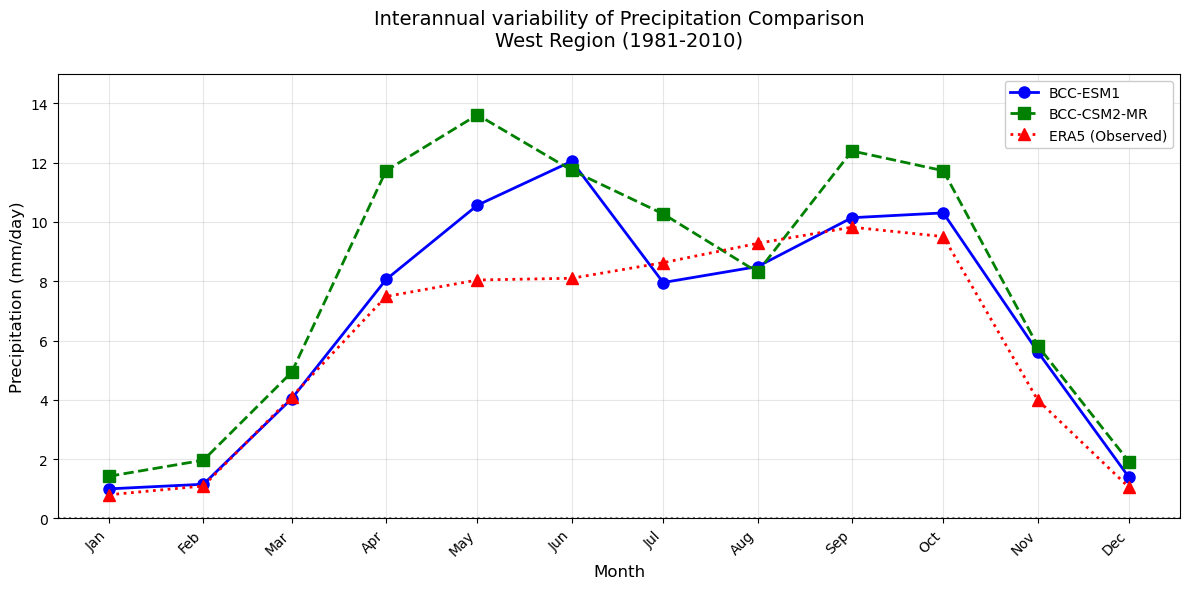

In [2]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

# Load data (already spatially averaged)
corr_esm1 = xr.open_dataset('BCC_ESM1_precip_monthly_clim_fldmean.nc')['pr'].squeeze()
corr_csm2 = xr.open_dataset('BCC_CSM2_precip_monthly_clim_fldmean.nc')['pr'].squeeze()
obs_precip = xr.open_dataset('obs_analysis_precip_monthly_global_fldmean.nc')['avg_tprate'].squeeze() 

# Check dimensions (should only have 'time')
print("BCC-ESM1 dimensions:", corr_esm1.dims)
print("BCC-CSM2 dimensions:", corr_csm2.dims)
print("ERA5 dimensions:", obs_precip.dims)

# Create month labels
months = pd.date_range(start="2020-01-01", periods=12, freq="MS")
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(months, corr_esm1, label="BCC-ESM1", color="blue", 
         linestyle='-', marker='o', markersize=8, linewidth=2)
plt.plot(months, corr_csm2, label="BCC-CSM2-MR", color="green", 
         linestyle='--', marker='s', markersize=8, linewidth=2)
plt.plot(months, obs_precip, label="ERA5 (Observed)", color="red", 
         linestyle=':', marker='^', markersize=8, linewidth=2)

# Format the plot
plt.xlabel("Month", fontsize=12)
plt.ylabel("Precipitation (mm/day)", fontsize=12)
plt.title("Interannual variability of Precipitation Comparison\nWest Region (1981-2010)", 
          fontsize=14, pad=20)
plt.xticks(months, month_labels, rotation=45, ha='right')
plt.ylim(0, 15)  # Adjust based on your data range
plt.axhline(0, color='gray', linestyle=':')  # Reference line
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, framealpha=1)

# Save and show
plt.tight_layout()
plt.savefig("precipitation_comparison_monthly.png", dpi=300, bbox_inches="tight")
plt.show() 

#### b) Temperature visualization

BCC-ESM1 dimensions: ('time',)
BCC-CSM2 dimensions: ('time',)
ERA5 dimensions: ('valid_time',)


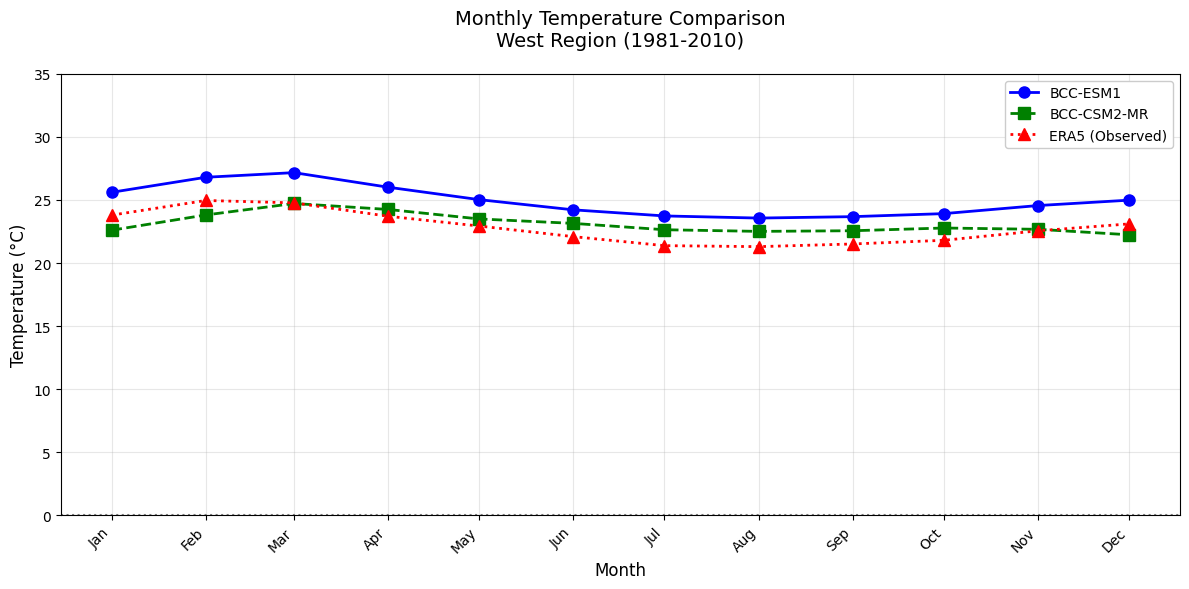

In [67]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

# Load data (already spatially averaged)
corr_esm1 = xr.open_dataset('BCC_ESM1_temp_monthly_clim_fldmean.nc')['tas'].squeeze()
corr_csm2 = xr.open_dataset('BCC_CSM2_temp_monthly_clim_fldmean.nc')['tas'].squeeze()
obs_temp = xr.open_dataset('obs_analysis_temp_monthly_clim_fldmean.nc')['t2m'].squeeze() 

# Check dimensions (should only have 'time')
print("BCC-ESM1 dimensions:", corr_esm1.dims)
print("BCC-CSM2 dimensions:", corr_csm2.dims)
print("ERA5 dimensions:", obs_temp.dims)

# Create month labels
months = pd.date_range(start="2020-01-01", periods=12, freq="MS")
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(months, corr_esm1, label="BCC-ESM1", color="blue", 
         linestyle='-', marker='o', markersize=8, linewidth=2)
plt.plot(months, corr_csm2, label="BCC-CSM2-MR", color="green", 
         linestyle='--', marker='s', markersize=8, linewidth=2)
plt.plot(months, obs_temp, label="ERA5 (Observed)", color="red", 
         linestyle=':', marker='^', markersize=8, linewidth=2)

# Format the plot
plt.xlabel("Month", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.title("Monthly Temperature Comparison\nWest Region (1981-2010)", 
          fontsize=14, pad=20)
plt.xticks(months, month_labels, rotation=45, ha='right')
plt.ylim(0, 35)  # Adjust based on your data range
plt.axhline(0, color='gray', linestyle=':')  # Reference line
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, framealpha=1)

# Save and show
plt.tight_layout()
plt.savefig("temperature_comparison_monthly.png", dpi=300, bbox_inches="tight")
plt.show()  

### a1) Temperature Bias

Model 1 temperature shape: (12,)
Model 2 temperature shape: (12,)
Observed temperature shape: (12,)


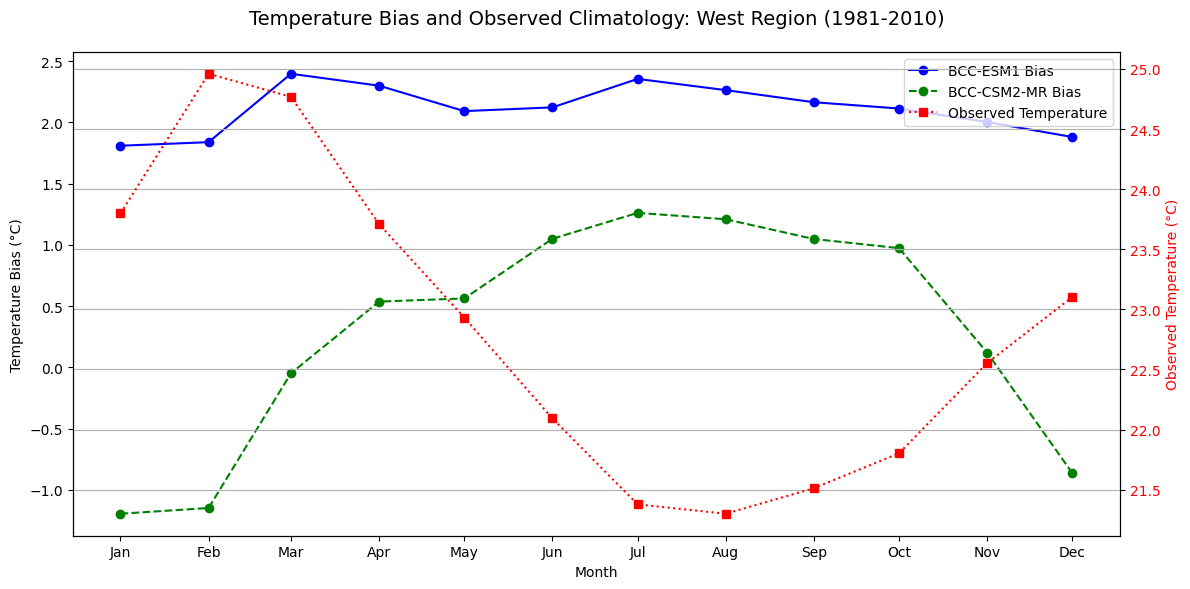

In [520]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

# Load processed data
bias_temp1 = xr.open_dataset('BCC_ESM1_temp_monthly_bias_global.nc')['tas']
bias_temp2 = xr.open_dataset('BCC_CSM2_temp_monthly_bias_global.nc')['tas']
obs_temp = xr.open_dataset('obs_analysis_temp_monthly_global.nc')['t2m']

# Average over space (latitude, longitude)   
temp1_annual = bias_temp1.mean(dim=['lat', 'lon'])
temp2_annual = bias_temp2.mean(dim=['lat', 'lon'])
obs_annual = obs_temp.mean(dim=['lat', 'lon'])

# Check the shapes of the data
print("Model 1 temperature shape:", temp1_annual.shape)
print("Model 2 temperature shape:", temp2_annual.shape)
print("Observed temperature shape:", obs_annual.shape)

# Create a time series plot
months = pd.date_range(start="2020-01-01", periods=12, freq="MS")  # Dummy dates for plotting

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature biases
ax1.plot(months, temp1_annual, label="BCC-ESM1 Bias", color="blue", linestyle='-', marker='o')
ax1.plot(months, temp2_annual, label="BCC-CSM2-MR Bias", color="green", linestyle='--', marker='o')

# Create secondary axis for observed temperature
ax2 = ax1.twinx()
ax2.plot(months, obs_annual, label="Observed Temperature", color="red", linestyle=':', marker='s')

# Set labels for primary axis
ax1.set_xlabel("Month")
ax1.set_ylabel("Temperature Bias (°C)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set labels for secondary axis
ax2.set_ylabel("Observed Temperature (°C)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legend
plt.title("Temperature Bias and Observed Climatology: West Region (1981-2010)", 
          fontsize=14, pad=20)
plt.xticks(months, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.savefig("temperature_bias_and_obs_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

### a2) Precipitation Bias

Model 1 Precipitation shape: (12,)
Model 2 Precipitation shape: (12,)
Observed Precipitation shape: (12,)


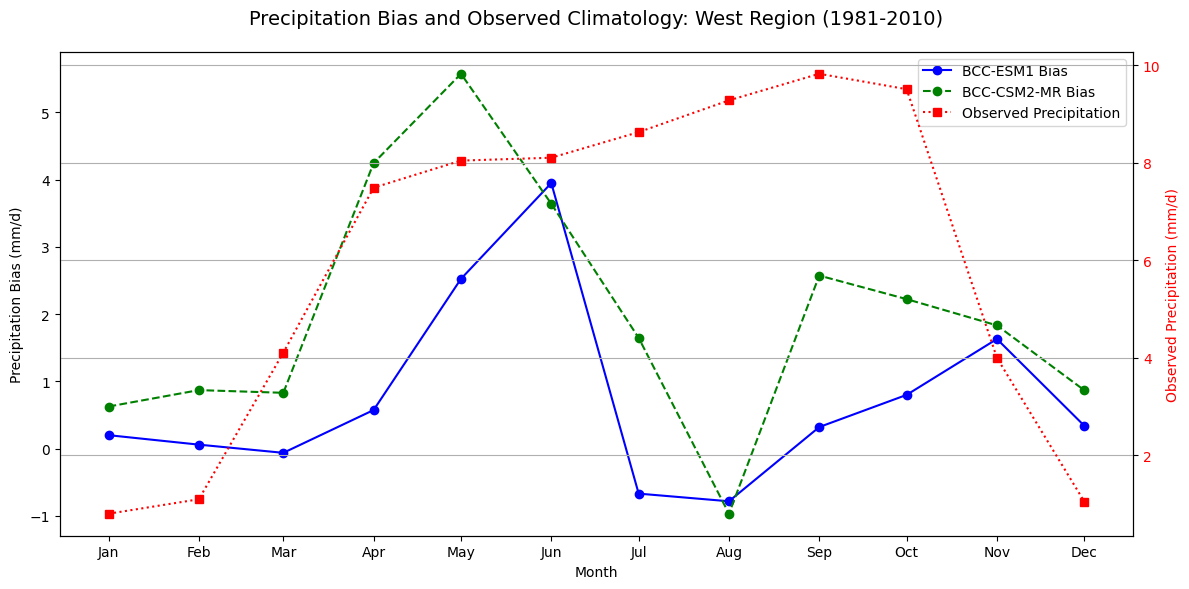

In [521]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import seaborn as sns  
import pandas as pd
from matplotlib.colors import ListedColormap

# Load processed data
bias_prec1 = xr.open_dataset('BCC_ESM1_precip_monthly_bias_global.nc')['pr']
bias_prec2 = xr.open_dataset('BCC_CSM2_precip_monthly_bias_global.nc')['pr']
obs_temp = xr.open_dataset('obs_analysis_precip_monthly_global.nc')['avg_tprate']

# Average over space (latitude, longitude)   
prec1_annual = bias_prec1.mean(dim=['lat', 'lon'])
prec2_annual = bias_prec2.mean(dim=['lat', 'lon'])
obs_annual = obs_temp.mean(dim=['lat', 'lon'])

# Check the shapes of the data
print("Model 1 Precipitation shape:", temp1_annual.shape)
print("Model 2 Precipitation shape:", temp2_annual.shape)
print("Observed Precipitation shape:", obs_annual.shape)

# Create a time series plot
months = pd.date_range(start="2020-01-01", periods=12, freq="MS")  # Dummy dates for plotting

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature biases
ax1.plot(months, prec1_annual, label="BCC-ESM1 Bias", color="blue", linestyle='-', marker='o')
ax1.plot(months, prec2_annual, label="BCC-CSM2-MR Bias", color="green", linestyle='--', marker='o')

# Create secondary axis for observed temperature
ax2 = ax1.twinx()
ax2.plot(months, obs_annual, label="Observed Precipitation", color="red", linestyle=':', marker='s')

# Set labels for primary axis
ax1.set_xlabel("Month")
ax1.set_ylabel("Precipitation Bias (mm/d)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set labels for secondary axis
ax2.set_ylabel("Observed Precipitation (mm/d)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legend
plt.title("Precipitation Bias and Observed Climatology: West Region (1981-2010)", 
          fontsize=14, pad=20)
plt.xticks(months, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.savefig("Precipitation_bias_and_obs_comparison.png", dpi=300, bbox_inches="tight")
plt.show() 

### a3) Precipitation Correlation 

Model 1 shape: (12,)
Model 2 shape: (12,)
ERA5 shape: (12,)


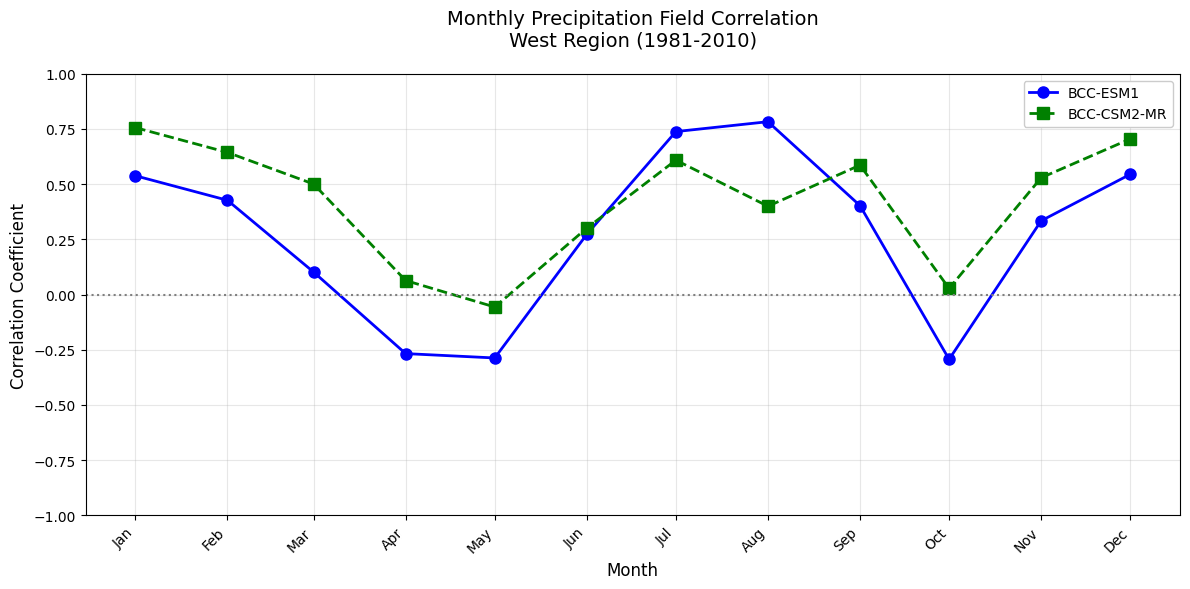

In [16]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

# Load the data and automatically remove size-1 dimensions
corr_esm1 = xr.open_dataset('BCC_ESM1_precip_monthly_clim_flipping_fldcor.nc')['avg_tprate'].squeeze()
corr_csm2 = xr.open_dataset('BCC_CSM2_precip_monthly_clim_flipping_fldcor.nc')['avg_tprate'].squeeze()


# Verify the shapes
print("Model 1 shape:", corr_esm1.shape)
print("Model 2 shape:", corr_csm2.shape)
print("ERA5 shape:", obs_precip.shape)

# Create month labels
months = pd.date_range(start="2020-01-01", periods=12, freq="MS")
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(months, corr_esm1, label="BCC-ESM1", color="blue", 
         linestyle='-', marker='o', markersize=8, linewidth=2)
plt.plot(months, corr_csm2, label="BCC-CSM2-MR", color="green", 
         linestyle='--', marker='s', markersize=8, linewidth=2)


# Format the plot
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.title("Monthly Precipitation Field Correlation\nWest Region (1981-2010)", 
          fontsize=14, pad=20)
plt.xticks(months, month_labels, rotation=45, ha='right')
plt.ylim(-1, 1)  # Correlation coefficient range
plt.axhline(0, color='gray', linestyle=':')  # Reference line
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, framealpha=1)

# Save and show
plt.tight_layout()
plt.savefig("precipitation_correlation_monthly.png", dpi=300, bbox_inches="tight")
plt.show() 

### a4) Temperature Correlation

Model 1 shape: (12,)
Model 2 shape: (12,)


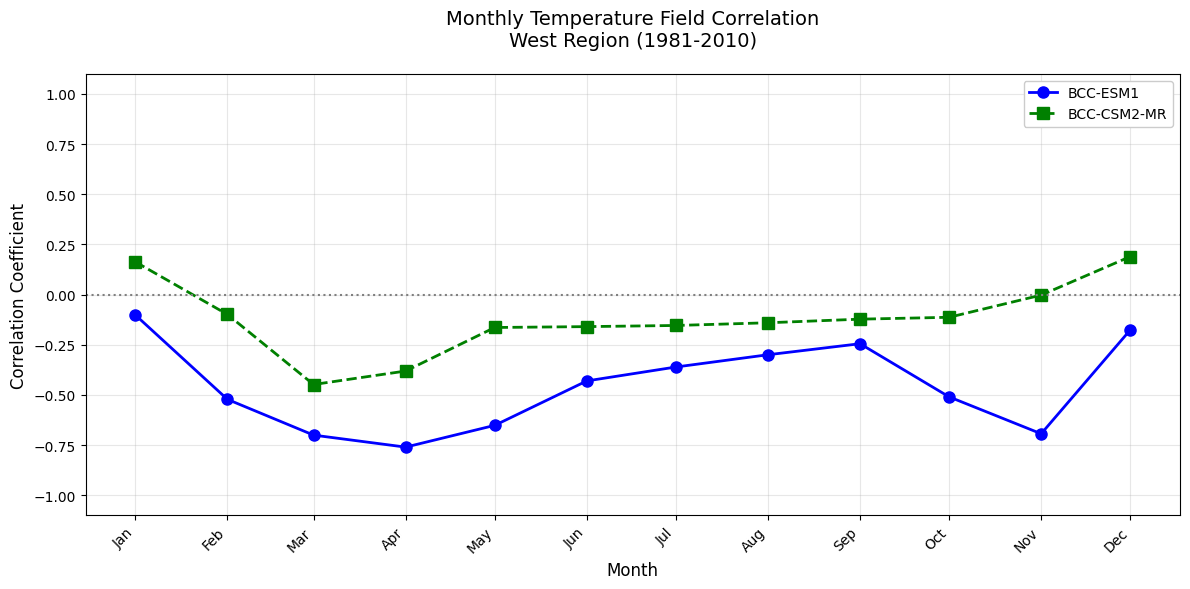

In [573]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Load and process the data
corr_esm1 = xr.open_dataset('BCC_ESM1_temp_monthly_clim_flipping_fldcor.nc')['t2m'].squeeze()
corr_csm2 = xr.open_dataset('BCC_CSM2_temp_monthly_clim_flipping_fldcor.nc')['t2m'].squeeze()

# Verify the shapes
print("Model 1 shape:", corr_esm1.shape)
print("Model 2 shape:", corr_csm2.shape)

# Create month labels
months = pd.date_range(start="2020-01-01", periods=12, freq="MS")
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the correlation data
plt.plot(months, corr_esm1, label="BCC-ESM1", color="blue", 
         linestyle='-', marker='o', markersize=8, linewidth=2)
plt.plot(months, corr_csm2, label="BCC-CSM2-MR", color="green", 
         linestyle='--', marker='s', markersize=8, linewidth=2)

# Format the plot
plt.xlabel("Month", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.title("Monthly Temperature Field Correlation\nWest Region (1981-2010)", 
          fontsize=14, pad=20)
plt.xticks(months, month_labels, rotation=45, ha='right')
plt.ylim(-1.1, 1.1)  # Correlation coefficient range
plt.axhline(0, color='gray', linestyle=':')  # Reference line
plt.grid(True, alpha=0.3)

# Add legend with improved formatting
plt.legend(fontsize=10, framealpha=1, loc='upper right')

# Save and show
plt.tight_layout()
plt.savefig("temperature_field_correlation.png", dpi=300, bbox_inches="tight")
plt.show()